In [5]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from numpy.linalg import multi_dot
import yfinance as yf

#set numpy random seed
np.random.seed(42)

import cufflinks as cf
cf.set_config_file(dimensions=((1000,600)))

#plotly express for EF plot
import plotly.express as px
px.defaults.width, px.defaults.height = 1000,600

#set precision
pd.set_option('display.precision', 4)

## Data retrieval

In [6]:
from sqlalchemy import create_engine, text
engine = create_engine('sqlite:///India')# Its a database

In [7]:
nifty50 = pd.read_html('https://en.wikipedia.org/wiki/NIFTY_50')[2].Symbol.to_list()

data = [yf.download(symbol+'.NS', start="2019-01-01", end="2023-12-31", progress=False).reset_index() for symbol in nifty50]

for frame, symbol in zip(data, nifty50):
    frame.to_sql(symbol, engine, if_exists='replace', index=False)

In [8]:
assets = sorted(['ICICIBANK', 'ITC', 'RELIANCE', 'TCS', 'ASIANPAINT'])
print(assets)

['ASIANPAINT', 'ICICIBANK', 'ITC', 'RELIANCE', 'TCS']


In [9]:
numofassets=len(assets)
numofassets
#set the number of portfolios we need to simulate for optimization
numofPortfolio = 5000

In [6]:
#extract close price from database
df = pd.DataFrame()
for asset in assets:
    query = f'SELECT Date, Close FROM {asset}'
    with engine.connect() as connection:
        df1=pd.read_sql_query(text(query), connection, index_col='Date')
        df1.columns = [asset]
    df = pd.concat([df, df1], axis=1)
    
    
df

,ASIANPAINT,ICICIBANK,ITC,RELIANCE,TCS
Date,,,,,
2019-01-01 00:00:00.000000,1371.5500,363.75,282.70,1024.9669,1902.8000
2019-01-02 00:00:00.000000,1383.3000,364.60,280.60,1011.6177,1923.3000
2019-01-03 00:00:00.000000,1388.3000,363.25,278.85,999.1371,1899.9500
2019-01-04 00:00:00.000000,1385.8500,365.20,280.95,1004.5316,1876.8500
2019-01-07 00:00:00.000000,1396.0000,367.70,281.65,1010.1091,1897.9000
...,...,...,...,...,...
2023-12-22 00:00:00.000000,3341.3000,994.30,455.20,2565.0500,3824.0000
2023-12-26 00:00:00.000000,3383.3501,995.10,456.45,2578.0500,3795.5500
2023-12-27 00:00:00.000000,3404.4500,1002.25,457.10,2586.8501,3811.2000


## Visualize timeseries

In [7]:
#plot price history
df['2021':].normalize().iplot(kind='line')

In [8]:
returns = df.pct_change().dropna()
annual_returns = round(returns.mean()*260*100,2)
annual_stdev = round(returns.std()*np.sqrt(260)*100,2)

#insert into dataframe
df2 = pd.DataFrame({
    'Ann ret': annual_returns,
    'Ann Vol': annual_stdev
})

df2

,Ann ret,Ann Vol
ASIANPAINT,22.73,26.75
ICICIBANK,26.85,33.41
ITC,13.96,26.78
RELIANCE,24.24,30.89
TCS,17.72,25.22


In [9]:
df2.iplot(kind='bar', orientation='h', shared_xaxes=True)

In [10]:
#portfolio composition
df2.reset_index().iplot(kind='pie', labels='index', values='Ann ret', textinfo = 'percent+label', hole=0.4)

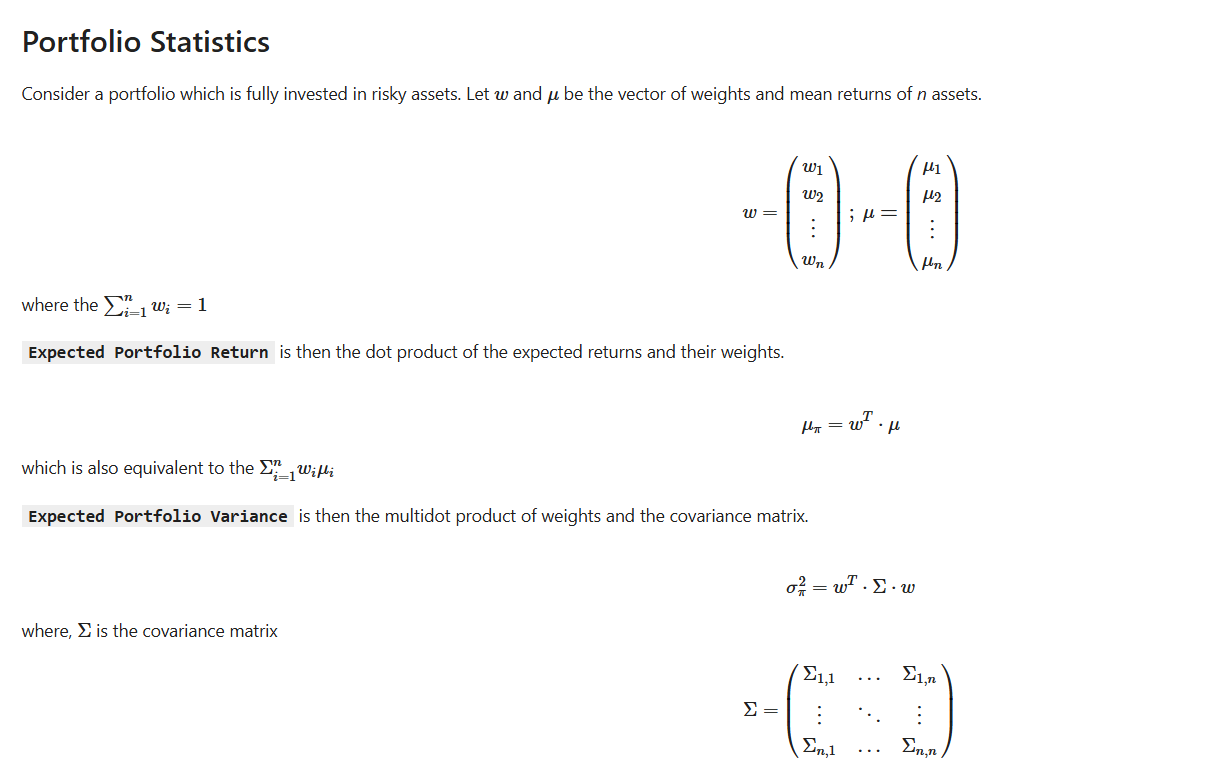

## Portfolio Simulation
Now, we will implement a Monte Carlo simulation to generate random portfolio weights on a larger scale and calculate the expected portfolio return, variance and sharpe ratio for every simulated allocation. We will then identify the portfolio with a highest return for per unit of risk.

In [55]:
wt = np.random.random(5)
wt

array([0.15599452, 0.05808361, 0.86617615, 0.60111501, 0.70807258])

In [56]:
sum_wt = sum(wt)
sum_wt

2.389441867818592

In [59]:
new_sum = sum(wt / sum_wt)
new_sum

0.9999999999999999

In [10]:
import numpy as np
weights=np.random.random(numofassets)
weights

array([0.37454012, 0.95071431, 0.73199394, 0.59865848, 0.15601864])

In [11]:
def portfolio_simulation(returns):
    
    #initialize the list
    ret=[]; vols=[]; wts=[]
    
    #simulate 5000 portfolios
    for i in range(numofPortfolio):
        
        #generate random weights
        weights=np.random.random(numofassets)
        
        #set weights such that their sum is 1
        weights /= np.sum(weights)
        
        
        #portfolio stats
        ret.append(weights.T@np.array(returns.mean()*260))
        vols.append(np.sqrt(multi_dot([weights.T, returns.cov()*260, weights])))
        wts.append(weights)
        
    #creating a dataframe for analysis
    data = {'port_rets': ret, 'port_vols': vols}
    for counter, symbol in enumerate(returns.columns.tolist()):
        data[symbol+' weight '] = [w[counter] for w in wts]
        
    portdf = pd.DataFrame(data)
    portdf['sharpe_ratio'] = portdf['port_rets'] / portdf['port_vols']
    
    return round(portdf, 4)

In [12]:
temp = portfolio_simulation(returns)
temp.head()

,port_rets,port_vols,ASIANPAINT weight,ICICIBANK weight,ITC weight,RELIANCE weight,TCS weight,sharpe_ratio
0,0.2189,0.2125,0.1332,0.3381,0.2603,0.2129,0.0555,1.0299
1,0.1855,0.1918,0.0653,0.0243,0.3625,0.2516,0.2963,0.9668
2,0.2097,0.2269,0.0093,0.4375,0.3755,0.0958,0.0820,0.9244
3,0.2034,0.1961,0.1057,0.1753,0.3024,0.2489,0.1678,1.0372
4,0.2074,0.1887,0.3279,0.0748,0.1566,0.1963,0.2444,1.0992


In [67]:
temp.iloc[temp.sharpe_ratio.idxmax() ]

port_rets             0.2184
port_vols             0.1953
ASIANPAINT weight     0.3230
ICICIBANK weight      0.1736
ITC weight            0.0861
RELIANCE weight       0.1893
TCS weight            0.2280
sharpe_ratio          1.1179
Name: 2087, dtype: float64

In [13]:
temp.describe().T

,count,mean,std,min,25%,50%,75%,max
port_rets,5000.0,0.2110,0.0132,0.1614,0.2024,0.2110,0.2196,0.2537
port_vols,5000.0,0.2016,0.0117,0.1822,0.1933,0.1996,0.2078,0.2788
ASIANPAINT weight,5000.0,0.2012,0.1140,0.0000,0.1124,0.2001,0.2785,0.7079
ICICIBANK weight,5000.0,0.1973,0.1130,0.0000,0.1082,0.1985,0.2755,0.7488
ITC weight,5000.0,0.1996,0.1128,0.0000,0.1112,0.2009,0.2768,0.7678
RELIANCE weight,5000.0,0.2030,0.1119,0.0001,0.1155,0.2029,0.2805,0.7058
TCS weight,5000.0,0.1988,0.1117,0.0001,0.1103,0.1982,0.2752,0.6781
sharpe_ratio,5000.0,1.0477,0.0459,0.7027,1.0235,1.0570,1.0814,1.1182


In [14]:
fig = px.scatter(
    temp, x='port_vols', y='port_rets', color='sharpe_ratio', 
    labels={'port_vols': 'Expected Volatility', 'port_rets': 'Expected Return','sharpe_ratio': 'Sharpe Ratio'},
    title="Monte Carlo Simulated Portfolio"
     ).update_traces(mode='markers', marker=dict(symbol='cross'))

# Plot max sharpe 
fig.add_scatter(
    mode='markers', 
    x=[temp.iloc[temp.sharpe_ratio.idxmax()]['port_vols']], 
    y=[temp.iloc[temp.sharpe_ratio.idxmax()]['port_rets']], 
    marker=dict(color='RoyalBlue', size=20, symbol='star'),
    name = 'Max Sharpe'
).update(layout_showlegend=False)

# Show spikes
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

## Efficient Frontier
The Efficient Frontier is formed by a set of portfolios offering the highest expected portfolio return for a certain volatility or offering the lowest volatility for a certain level of expected returns.

Return objective:

$$ \min_{w_1,w_2,...,w_n}\sigma^{2}_p(w_1,w_2,...,w_n)$$

Subject to,

$$ E[R_p] = m$$

#### Risk constraint:

$$\max_{w_1,w_2,...,w_n}E[R_p(w_1,w_2,...,w_n)]$$

Subject to,

$$\sigma_p^{2}(w_1,w_2,...,w_n) = v^{2}$$

where, $\sum_{i=1}^{n}w_i = 1$

 for the above objectives.

We can use numerical optimization to achieve this objective. The goal of optimization is to find the optimal value of the objective function by adjusting the target variables operating withing some boundary conditions and constraints.

Constrained Optimization
Construction of optimal portfolios is a constrained optimization problem where we specify some boundary conditions and constraints. The objective function here is a function returning maximum sharpe ratio, minimum variance (volatility) and the target variables are portfolio weights. We will use the $minimize$ function from $scipy$ optimization module to achieve our objective.

In [16]:
import scipy.optimize as sco
#sco.optimize?

### Portfolio Statistics

Let's subsume key statistics into a function which can be used for optimization exercise.

In [17]:
def portfolio_stats(weights):
    
    weights = np.array(weights)
    port_ret = weights.T@np.array(returns.mean()*260)
    port_vol = np.sqrt(multi_dot([weights.T,returns.cov()*260, weights]))
    
    return np.array([port_ret, port_vol, port_ret/port_vol])

In [22]:
#minimizing the volatility

def min_volatility(weights):
    return portfolio_stats(weights)[1]

#minimizing the variance

def min_variance(weights):
    return portfolio_stats(weights)[1]**2

# Maximizing sharpe ratio
def max_sharpe_ratio(weights):
    return -portfolio_stats(weights)[2]
    

In [20]:
#specify the constraints
cons = ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0,1) for x in range(numofassets))
initial_wts = numofassets*[1./numofassets]  

In [23]:
# Optimizing for maximum sharpe ratio
opt_sharpe = sco.minimize(max_sharpe_ratio, initial_wts, method='SLSQP', bounds=bnds, constraints=cons)

# Optimizing for minimum variance
opt_var = sco.minimize(min_variance, initial_wts, method='SLSQP', bounds=bnds, constraints=cons)

In [24]:
opt_sharpe

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -1.1186600513873315
       x: [ 3.251e-01  1.968e-01  8.503e-02  1.770e-01  2.162e-01]
     nit: 5
     jac: [-1.373e-04  5.700e-04 -2.605e-04 -5.494e-04  2.398e-04]
    nfev: 30
    njev: 5

In [25]:
opt_var

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 0.03313696253010405
       x: [ 2.553e-01  4.434e-02  2.944e-01  8.664e-02  3.193e-01]
     nit: 7
     jac: [ 6.631e-02  6.630e-02  6.639e-02  6.622e-02  6.615e-02]
    nfev: 42
    njev: 7

In [26]:
#Efficient Frontier (ef)
targetrets = np.linspace(0.15,0.24,100)
tvols=[]

for tr in targetrets:
    
    ef_cons = ({'type': 'eq', 'fun': lambda x: portfolio_stats(x)[0] - tr},
              {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
    
    opt_ef = sco.minimize(min_volatility, initial_wts, method='SLSQP', bounds=bnds, constraints=ef_cons)
    
    tvols.append(opt_ef['fun'])\
    
targetvols = np.array(tvols)

In [27]:
efport = pd.DataFrame({
    'targetrets' : np.around(100*targetrets,2),
    'targetvols': np.around(100*targetvols,2),
    'targetsharpe': np.around(targetrets/targetvols,2)
})

efport.head()

,targetrets,targetvols,targetsharpe
0,15.00,21.95,0.68
1,15.09,21.66,0.70
2,15.18,21.39,0.71
3,15.27,21.14,0.72
4,15.36,20.93,0.73


In [28]:
# Plot efficient frontier portfolio
fig = px.scatter(
    efport, x='targetvols', y='targetrets',  color='targetsharpe',
    labels={'targetrets': 'Expected Return', 'targetvols': 'Expected Volatility','targetsharpe': 'Sharpe Ratio'},
    title="Efficient Frontier Portfolio"
     ).update_traces(mode='markers', marker=dict(symbol='cross'))


# Plot maximum sharpe portfolio
fig.add_scatter(
    mode='markers',
    x=[100*portfolio_stats(opt_sharpe['x'])[1]], 
    y=[100*portfolio_stats(opt_sharpe['x'])[0]],
    marker=dict(color='red', size=20, symbol='star'),
    name = 'Max Sharpe'
).update(layout_showlegend=False)

# Plot minimum variance portfolio
fig.add_scatter(
    mode='markers',
    x=[100*portfolio_stats(opt_var['x'])[1]], 
    y=[100*portfolio_stats(opt_var['x'])[0]],
    marker=dict(color='green', size=20, symbol='star'),
    name = 'Min Variance'
).update(layout_showlegend=False)

# Show spikes
fig.update_xaxes(showspikes=True)
fig.update_yaxes(showspikes=True)
fig.show()

In [ ]:
# # OPTIONAL 
# # To save the figure, you might have to install kaleido for earlier version of plotly
# @pip install -U kaleido

# # Save as interactive plot
# fig.write_html("images/ef.html")

# # Save as portable network graphics
# fig.write_image("images/ef.png")

# # Save as portdable document format
# fig.write_image("images/ef.pdf")